# Assignment 9
## Data driven predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

Importing the external files:


In [2]:
ExternalFilesFolder =  r"C:\Users\Gilberto\Desktop\poli\Energy building systems\Data-driven_Building_simulation_Polimi_EETBS\Data"
ConsumptionFileName= "consumption_5545.csv"
TemperatureFileName= "Austin_weather_2014.csv"
IrradianceFileName= "irradiance_2014_gen.csv"

path_consumptionFile = os.path.join(ExternalFilesFolder,ConsumptionFileName)
path_TemperatureFile = os.path.join(ExternalFilesFolder,TemperatureFileName)
path_IrradianceFile = os.path.join(ExternalFilesFolder,IrradianceFileName)

Reading the files and changing the indexes in order to have the possibility to use them as time datas:

In [3]:
DF_consumption = pd.read_csv(path_consumptionFile,sep=",", index_col=0)
DF_weather = pd.read_csv(path_TemperatureFile,sep=";",index_col=0)
DF_irradianceSource = pd.read_csv(path_IrradianceFile,sep=";",index_col=1)

PreviousIndex_c = DF_consumption.index
NewIndex_c= pd.to_datetime(PreviousIndex_c)
PreviousIndex_w = DF_weather.index
NewIndex_w= pd.to_datetime(PreviousIndex_w)
PreviousIndex_i = DF_irradianceSource.index
NewIndex_i= pd.to_datetime(PreviousIndex_i)

DF_consumption.index =NewIndex_c
DF_weather.index=NewIndex_w
DF_irradianceSource.index=NewIndex_i

Setting Data Frames for the needed datas: temperature, AC consumption and irradiance (wich is correlated to the PV generation):

In [4]:
DF_Temperature= DF_weather[["temperature"]]

DF_irradiance=DF_irradianceSource[["gen"]]
DF_irradiance[DF_irradiance["gen"]<0] = 0 #setting at zero all the negative datas

DF_consumption=DF_consumption

DF_joined = DF_consumption.join([DF_Temperature,DF_irradiance])
DF_joined.dropna(inplace=True)

C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

Creating a copy of my datas which will be modified for predictions, and shifting the temperature datas due to the different time zone of the measurements:

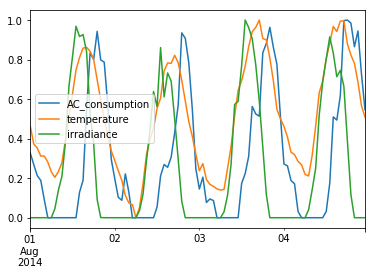

In [5]:
df_mod=DF_joined.copy()
df_mod.columns=["AC_consumption", "temperature","irradiance"]

df_mod["temperature"]=df_mod["temperature"].shift(-5)
df_mod.dropna(inplace=True)

#plotting a normalized version of my DF to see the qualitative behaviour:
df_mod_choosendates=df_mod["2014-08-01":"2014-08-04"]
df_mod_normalized_choosendates=(df_mod_choosendates-df_mod_choosendates.min())/(df_mod_choosendates.max()-df_mod_choosendates.min())
df_mod_normalized_choosendates.plot()
plt.show()

Creating lagged features and applying them to my dataframe in order to have meaningful datas for my predictions:

In [6]:

lag_start=1
lag_end=6
lag_interval=1
df=df_mod

def lagfeature(df, column_name, lag_start,lag_end,lag_interval):
    for i in range(lag_start, lag_end+1, lag_interval):
    
        new_column_name= column_name + "-"+ str(i)+"h"
        df[new_column_name]=df[column_name].shift(i)
        df.dropna(inplace=True)
    return df

df_mod= lagfeature(df_mod, "irradiance", 3,6,1)
df_mod= lagfeature(df_mod, "temperature", 1,6,1)
df_mod= lagfeature(df_mod, "AC_consumption", 1,24,1)
df_mod.head(24)

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-15h,AC_consumption-16h,AC_consumption-17h,AC_consumption-18h,AC_consumption-19h,AC_consumption-20h,AC_consumption-21h,AC_consumption-22h,AC_consumption-23h,AC_consumption-24h
2014-01-15 09:00:00,0.0,39.31,2.191083,0.000000,0.000000,0.000000,0.000000,39.24,40.81,40.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 10:00:00,0.0,43.73,3.120000,0.078900,0.000000,0.000000,0.000000,39.31,39.24,40.81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 11:00:00,0.0,49.51,3.865200,0.862767,0.078900,0.000000,0.000000,43.73,39.31,39.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 12:00:00,0.0,53.34,4.267967,2.191083,0.862767,0.078900,0.000000,49.51,43.73,39.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 13:00:00,0.0,57.37,4.310133,3.120000,2.191083,0.862767,0.078900,53.34,49.51,43.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 14:00:00,0.0,58.34,3.985133,3.865200,3.120000,2.191083,0.862767,57.37,53.34,49.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 15:00:00,0.0,60.00,3.329083,4.267967,3.865200,3.120000,2.191083,58.34,57.37,53.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 16:00:00,0.0,62.22,2.062200,4.310133,4.267967,3.865200,3.120000,60.00,58.34,57.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 17:00:00,0.0,62.35,0.457383,3.985133,4.310133,4.267967,3.865200,62.22,60.00,58.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 18:00:00,0.0,61.17,0.000000,3.329083,3.985133,4.310133,4.267967,62.35,62.22,60.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's add time-related parameters extracted from the indexes converted before:

In [7]:
df_mod["hour"]=df_mod.index.hour
df_mod["day_of_week"]=df_mod.index.dayofweek
df_mod["week_of_year"]=df_mod.index.week
df_mod["month"]=df_mod.index.month

I need to correlate time and consumption, but time always restart from 0 while consumption values are continuous.
To avod this problem I convert "hour" into a radiant angle so it's possible to use sin and cos functions with it:

In [8]:
df_mod["sin_hour"]=np.sin(df_mod.index.hour*2*np.pi/24)
df_mod["cos_hour"]=np.cos(df_mod.index.hour*2*np.pi/24)
df_mod.head()

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-21h,AC_consumption-22h,AC_consumption-23h,AC_consumption-24h,hour,day_of_week,week_of_year,month,sin_hour,cos_hour
2014-01-15 09:00:00,0.0,39.31,2.191083,0.000000,0.000000,0.000000,0.0000,39.24,40.81,40.74,...,0.0,0.0,0.0,0.0,9,2,3,1,7.071068e-01,-0.707107
2014-01-15 10:00:00,0.0,43.73,3.120000,0.078900,0.000000,0.000000,0.0000,39.31,39.24,40.81,...,0.0,0.0,0.0,0.0,10,2,3,1,5.000000e-01,-0.866025
2014-01-15 11:00:00,0.0,49.51,3.865200,0.862767,0.078900,0.000000,0.0000,43.73,39.31,39.24,...,0.0,0.0,0.0,0.0,11,2,3,1,2.588190e-01,-0.965926
2014-01-15 12:00:00,0.0,53.34,4.267967,2.191083,0.862767,0.078900,0.0000,49.51,43.73,39.31,...,0.0,0.0,0.0,0.0,12,2,3,1,1.224647e-16,-1.000000
2014-01-15 13:00:00,0.0,57.37,4.310133,3.120000,2.191083,0.862767,0.0789,53.34,49.51,43.73,...,0.0,0.0,0.0,0.0,13,2,3,1,-2.588190e-01,-0.965926


Adding and applying other 2 features for improving my predictions:
WeekendDetector to know if the day is a working day or not, and DayDetector to set the working hours in a day :

In [9]:
def weekendDetector(day):
    if (day==5 or day==6):
        weekend=1
    else:
        weekend=0
    return weekend
    
df_mod["weekend"]=df_mod["day_of_week"].apply(weekendDetector)


def dayDetector(hour):
    if (hour<19 and hour>9):
        daylevel=1
    else:
        daylevel=0
    return daylevel
    
df_mod["working_time"]=df_mod["hour"].apply(dayDetector)

Finding correlations between each data:

In [10]:
df_mod.corr()

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-23h,AC_consumption-24h,hour,day_of_week,week_of_year,month,sin_hour,cos_hour,weekend,working_time
AC_consumption,1.000000,0.569263,-0.012922,0.364403,0.467469,0.533798,0.555348,0.609093,0.637359,0.650606,...,0.849278,0.899832,0.361631,-0.015623,0.139350,0.129258,-0.438918,0.212853,-0.006854,-0.008530
temperature,0.569263,1.000000,0.327150,0.449056,0.429531,0.385102,0.322403,0.990926,0.968227,0.935128,...,0.578450,0.539153,0.243949,0.036900,0.192046,0.165154,-0.332610,-0.145392,0.036360,0.276419
irradiance,-0.012922,0.327150,1.000000,0.560637,0.329328,0.103674,-0.095145,0.238234,0.140789,0.043685,...,0.091742,-0.025492,0.167694,-0.030601,-0.027485,-0.033833,-0.237324,-0.740807,-0.032422,0.767364
irradiance-3h,0.364403,0.449056,0.560637,1.000000,0.925887,0.769235,0.560617,0.439007,0.397375,0.327032,...,0.442399,0.342837,0.466083,-0.030458,-0.027620,-0.033972,-0.692302,-0.355468,-0.032474,0.605998
irradiance-4h,0.467469,0.429531,0.329328,0.925887,1.000000,0.925888,0.769242,0.449060,0.439012,0.397383,...,0.509422,0.442400,0.564446,-0.030271,-0.027610,-0.033978,-0.760590,-0.163849,-0.032479,0.429156
irradiance-5h,0.533798,0.385102,0.103674,0.769235,0.925888,1.000000,0.925891,0.429547,0.449075,0.439027,...,0.531420,0.509425,0.644464,-0.030118,-0.027531,-0.033934,-0.776878,0.038947,-0.032384,0.236023
irradiance-6h,0.555348,0.322403,-0.095145,0.560617,0.769242,0.925891,1.000000,0.385140,0.429582,0.449105,...,0.509430,0.531426,0.671813,-0.029612,-0.027281,-0.033745,-0.740048,0.239071,-0.032384,0.040850
temperature-1h,0.609093,0.990926,0.238234,0.439007,0.449060,0.429547,0.385140,1.000000,0.990926,0.968233,...,0.606895,0.578437,0.263756,0.035634,0.192929,0.165880,-0.359646,-0.054087,0.036266,0.206719
temperature-2h,0.637359,0.968227,0.140789,0.397375,0.439012,0.449075,0.429582,0.990926,1.000000,0.990928,...,0.620865,0.606883,0.271138,0.034483,0.193814,0.166611,-0.362090,0.041092,0.036085,0.120543
temperature-3h,0.650606,0.935128,0.043685,0.327032,0.397383,0.439027,0.449105,0.968233,0.990928,1.000000,...,0.619779,0.620847,0.262642,0.033700,0.194730,0.167370,-0.339765,0.133658,0.036216,0.029418
